# Interpretation of Logistic Regression

In [1]:
import os

# Change the current working directory
os.chdir('/Users/Sari/Documents/Code/Semester 4 workbooks')

In [2]:
# Import Necessary Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import seaborn as sns

/var/folders/25/82ztpk21087b258r7gs0n3m00000gn/T/ipykernel_18010/4276896713.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


#### Let us begin from where we left off in the last workbook. Loading the tree data and applying the same data wrangling I did in my last file.

#### Get the data ready for fitting a logistic regression by dropping missing values and adding a constant for the intercept. 

In [3]:
# Load tree data
df = pd.read_csv('data/clean_tree_data.csv')
# the dataset is much bigger than we need, sampling from it
data_n = 2000
df = df.sample(data_n, random_state=31415)

# taller than 10m is a positive outcome otherwise negative
df['is_tall'] = pd.Series(df['tree_height_fixed'] > 10).astype(int)
Y = df['is_tall']

# streamline tree treatment for efficiency
df['growing_freely'] = pd.Series(
    df['tree_treatment'] == 'Boom vrij uitgroeiend'
).astype(int)

# Create design matrix 
X = pd.DataFrame({
    'diameter': df['diameter'],
    'age': df['age'],
    'growing_freely': df['growing_freely'],
})

categorical_vars = ['species_group']

# if I need to refer to each dummy column of a category I can use this dict
indexed_dummy_columns = dict()

for category in categorical_vars:
    dummies = pd.get_dummies(df[category], prefix=category, drop_first=True)
    dummies = dummies.astype(float)
    indexed_dummy_columns[category] = dummies.columns
    X = pd.concat([X, dummies], axis=1)

X_with_intercept = sm.add_constant(X)
X_with_intercept.dropna(inplace=True)


#### i) The `Homogeneous Probability` model:

#### Fit a logistic regression model with just an intercept, no other covariates. Plot the empirical posterior distribution of the baseline coefficients: a) on the log-odds scale; b) on the odds scale; c) on the probability scale. Interpret this result. 

In [4]:
# Fit the model 
X_just_intercept = X_with_intercept[['const']]
homogeneous_model = sm.Logit(Y, X_just_intercept).fit()

Optimization terminated successfully.
         Current function value: 0.625734
         Iterations 4


In [5]:
# Get summary results
homogeneous_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                is_tall   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1999
Method:                           MLE   Df Model:                            0
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:               3.267e-11
Time:                        14:06:32   Log-Likelihood:                -1251.5
converged:                       True   LL-Null:                       -1251.5
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7607      0.048     15.849      0.000       0.667       0.855
==============================================================================
"""

In [6]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = homogeneous_model.params
beta_cov = homogeneous_model.cov_params()

In [7]:
# Number of simulations
n_sim = 1000

# Simulate beta coefficients:

# on the log-odds scale
simulated_base_log_odds = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_sim)

# on the odds scale
simulated_base_odds = np.exp(simulated_base_log_odds)

# on the probability scale
simulated_base_prob = logistic_sigmoid(simulated_base_log_odds)

# simulations array
simulated_base = np.stack((simulated_base_log_odds, simulated_base_odds, simulated_base_prob), axis=1)

In [8]:
print(simulated_base)

[[0.76608866 2.15133518 0.68267419]
 [0.69354223 2.00079026 0.66675445]
 [0.71511641 2.04442467 0.67153071]
 ...
 [0.72404937 2.06276924 0.67349809]
 [0.77226809 2.16467035 0.68401132]
 [0.74466175 2.10572905 0.67801441]]


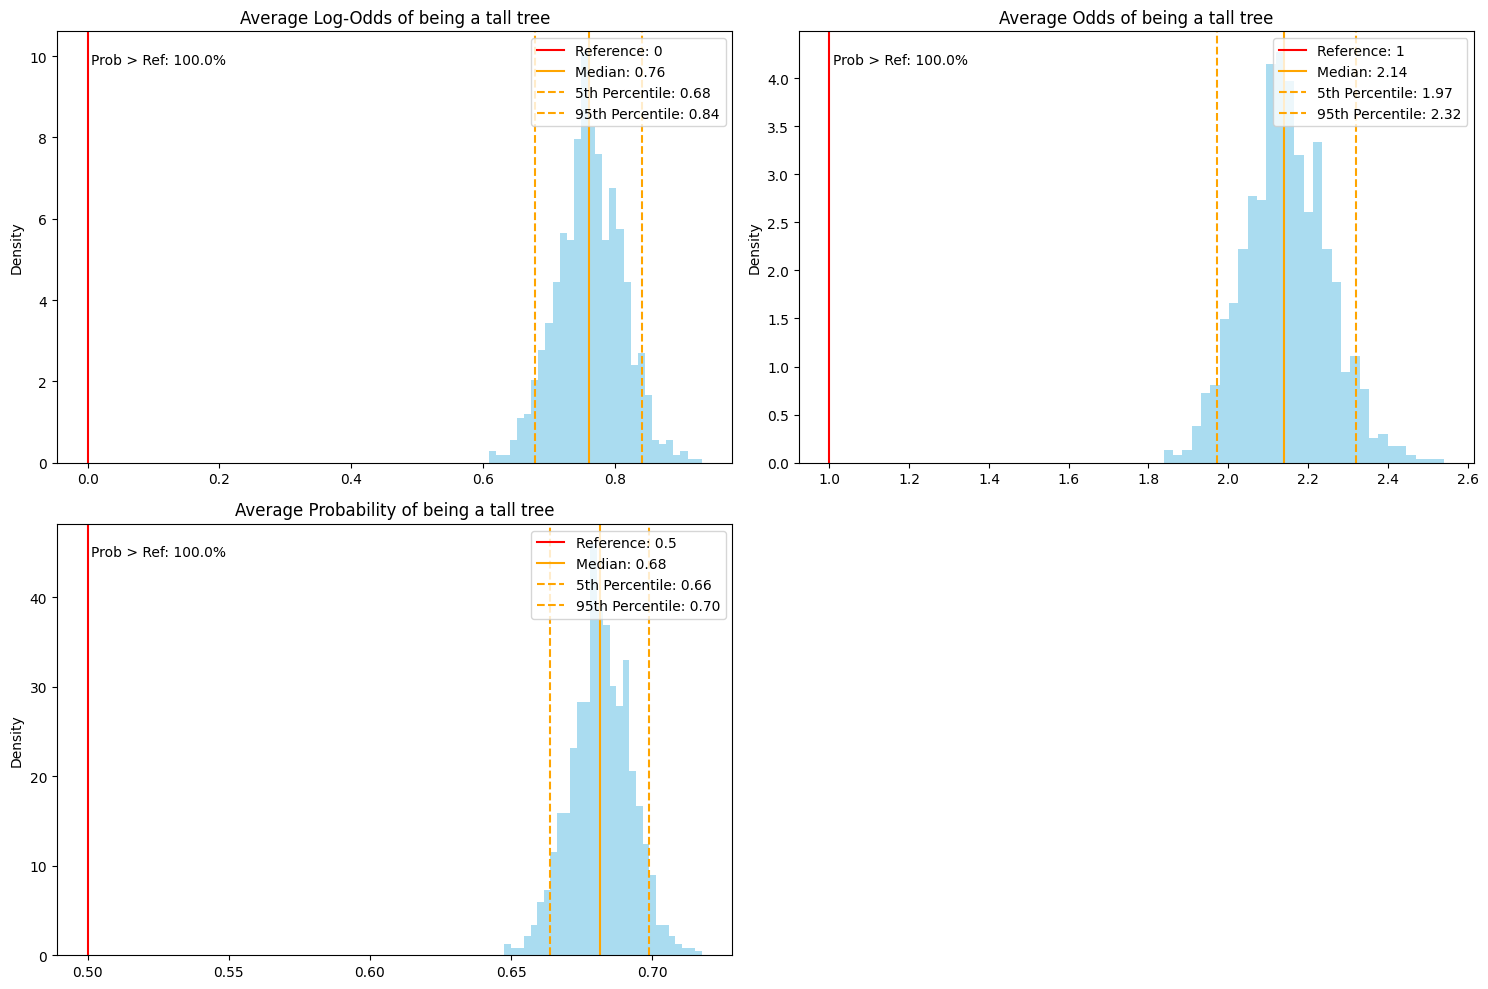

In [9]:
# Calculate statistics for each coefficient
medians = np.median(simulated_base, axis=0)
lower_quantiles = np.percentile(simulated_base, 5, axis=0)
upper_quantiles = np.percentile(simulated_base, 95, axis=0)
references = [0, 1, 0.5]  # Reference values for log-odds, odds, probability
prob_positive = [np.mean(simulated_base[:, i] > references[i]) for i in range(3)]

# Plot names 
col_names = ['Log-Odds', 'Odds', 'Probability']

# Plot histograms of each metric
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust for the number of metrics
axs = axs.flatten()

for i in range(len(col_names)):
    ax = axs[i]
    ax.hist(simulated_base[:, i], bins=30, density=True, alpha=0.7, color='skyblue')
    
    # Add vertical lines for reference, median, and 90% interval
    ax.axvline(references[i], color='red', linestyle='-', label=f'Reference: {references[i]}')
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    ax.text(0.05, 0.95, f'Prob > Ref: {prob_positive[i]*100:.1f}%', transform=ax.transAxes, verticalalignment='top')
    
    ax.set_title(f'Average {col_names[i]} of being a tall tree')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

# Hide empty subplot for uneven number of metrics
if len(col_names) % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

#### Answer: 

These 3 values represent the same thing, the chance that a tree is tall or not. The main difference is the range of values that each can take: log-odds can go from -infinity to +infinity, odds from 0 to +infinity and probability from 0 to 1.

The log-odds represents the value of our coefficient. A positive coefficient indicates that a tree is more likely to be tall than not. It's more difficult to interpret the log-odds, so we convert it to probabilities and odds.

The odds represent the ratio of success to failure, how many tall trees we should see for each small tree, in this case around 2 tall trees for each small tree seem like the plausible true odds of a tree being tall in Amsterdam. 

Probabilities: for any given tree in Amsterdam, the true probability of that tree being "tall" is most likely to be around 0.66, with a credibility interval at 90% of 0.66 to 0.70, so we can plausibly say that the probability of a tree being tall has a 90% chance of sitting between 0.66 and 0.70. Higher and lower values than this probability are less plausible.

#### ii) The `Heterogeneous Probability` model with one binary covariate: 

#### a) Let us build on the previous model. Firstly calculate the AIC (Akaike Information Criteria) of this homogeneous probability model - keep stock of this number, as we will use it to compare models in a few beats.

In [10]:
aic = homogeneous_model.aic
print("AIC:", aic)

AIC: 2504.934502164646


#### b) Now let us add some complexity to our model. Let's model the fact that older trees are more likely to be tall than younger trees. (According to my theory, trees grow over time.)

In [11]:
# Fit the model with college education
model = sm.Logit(Y, X_with_intercept[['const', 'age']]).fit()

Optimization terminated successfully.
         Current function value: 0.542116
         Iterations 6


In [12]:
# Get summary results
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:                is_tall   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1998
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:                  0.1336
Time:                        14:06:33   Log-Likelihood:                -1084.2
converged:                       True   LL-Null:                       -1251.5
Covariance Type:            nonrobust   LLR p-value:                 1.022e-74
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2354      0.125     -9.867      0.000      -1.481      -0.990
age            0.0602      0.004     16.236      0.000       0.053       0.067


In [13]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
betas_mean = model.params
betas_cov = model.cov_params()

In [14]:
# Simulate values of each regression coefficient from the posterior distribution 

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=betas_mean, cov=betas_cov, size=n_simulations)

In [15]:
# Derive odds from log-odds coefficients 
simulated_betas_odds = np.exp(simulated_betas)

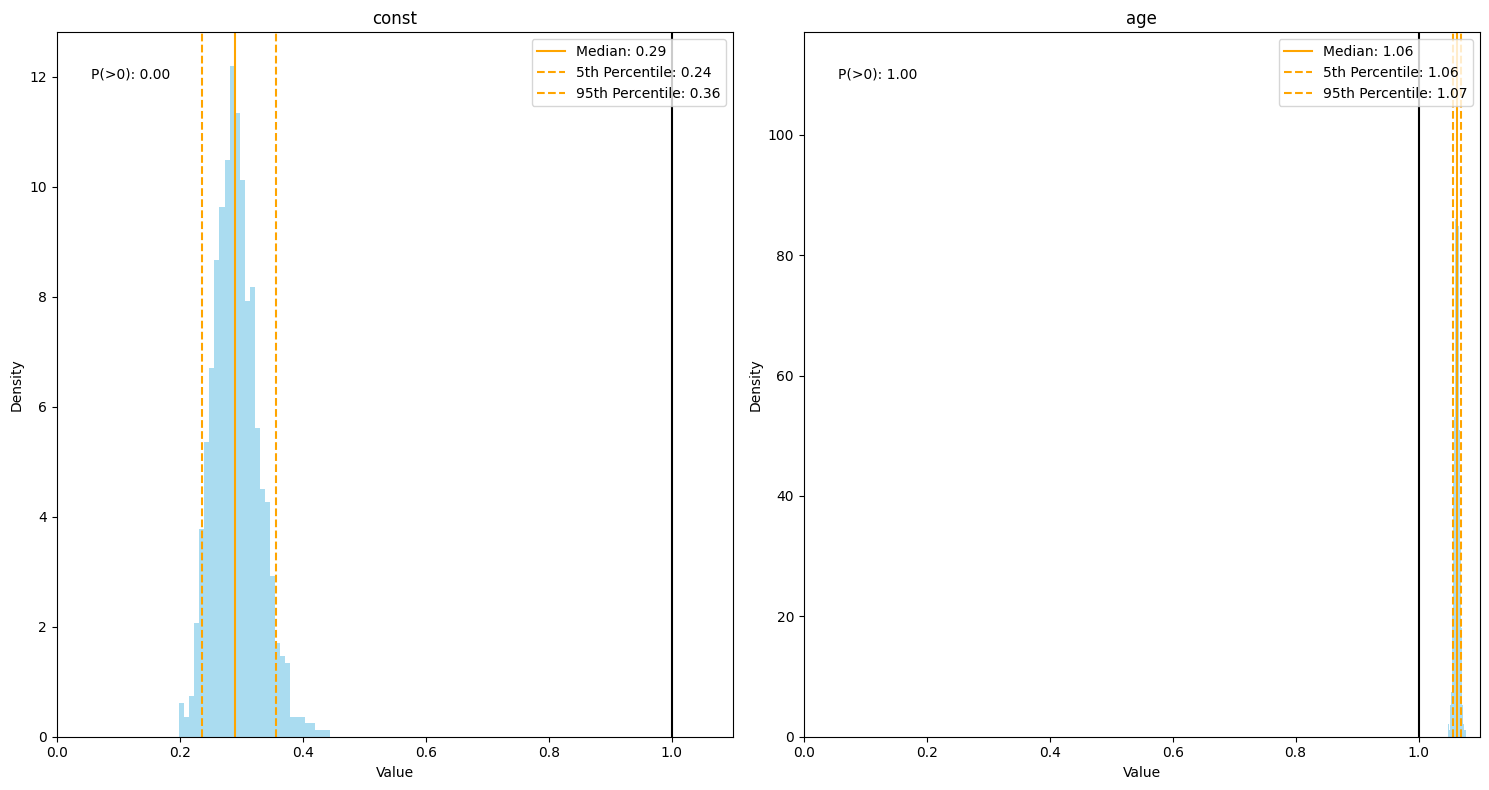

In [16]:
# Calculate statistics for each coefficient
medians = np.median(simulated_betas_odds, axis=0)
lower_quantiles = np.percentile(simulated_betas_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas_odds, 95, axis=0)
prob_positive = np.mean(simulated_betas_odds > 1, axis=0)

# Plot names 
col_names = ['const','age']


# Plot histograms of each coefficient
num_rows = (simulated_betas.shape[1] + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(simulated_betas.shape[1]):
    ax = axs[i]
    ax.hist(simulated_betas_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>0): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{ col_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1,abs(simulated_betas_odds[:, i]).max())) 
    
# Hide empty subplot
if simulated_betas.shape[1] % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()


#### c) Interpret the coefficients.

#### Answer: 

The intercept: in this case, this represents the odds of a tree being tall, assuming its age to be zero. So for a given tree that has just been planted, the most likely true odds of it being already 10m+ high are 0.3. This is a bit weird, and possibly due to the incompleteness of my model. In my data, "age" actually represents time-since-planted, so it's possible that tall trees are being transplanted in recent years too. In any case, it means that newly planted trees are much less likely to be tall (we would expect more than 3 small zero-year old trees for each 1 tall zero-year old tree). The 90th percentile for our intercept is pretty wide too (between 0.24 and 0.36), so we have a lot of uncertainty about the true odds of zero-year old trees being tall.

The age coefficient: On the other hand, the 90th percentile for our age coefficient is very small, between 1.06 and 1.07. The distribution looks almost like a straight line. We have a lot of certainty about the relationship between age and the odds of being a tall tree. Since the value is above one, it means that each unit of age increases the odds of a tree being tall. Since this is a numerical value, this is how we can interpret it: a tree that is one year older than another has 1.06 times the odds of being tall than the younger tree. The odds of a 1-year-old tree being tall are 1.06 times higher than that of a 0-year-old tree.

#### d) Get the AIC of this model, and comment on its value compared to the previous model. 

In [17]:
aic = model.aic
print("AIC:", aic)

AIC: 2172.465241727814


#### Answer: 

This is a lower value, which suggests that we have a model that fits our sample better accounting for complexity. 

#### ii) The `Heterogeneous Probability` model with multiple covariates and interactions: 

#### a) Fit a logit model with diameter, age, free growth, and genus, and an interaction between age and growing freely (theorising that older trees who are left to grow will grow taller, whereas older trees that are being cut may plateau before becoming tall).

(Tip: center and divide age by 10, so it is interpretable as a `10 year increase over the average age` as opposed to a `1 year increase over 0 years` for a 1-unit change)

In [18]:
X_with_intercept['age'] = (X_with_intercept['age']- X_with_intercept['age'].mean())/10

In [19]:
age_free_growth = X_with_intercept['age'] * X_with_intercept['growing_freely']
# I want this column to be on the left so we can look at it when plotting the coefs
X_with_intercept.insert(0, 'age_free_growth', age_free_growth)


In [20]:
# Fit the model with all that data
model = sm.Logit(Y, X_with_intercept).fit(maxiter=1000, method='bfgs')

# Get summary results
summary = model.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.342806
         Iterations: 300
         Function evaluations: 301
         Gradient evaluations: 301
                           Logit Regression Results                           
Dep. Variable:                is_tall   No. Observations:                 2000
Model:                          Logit   Df Residuals:                     1952
Method:                           MLE   Df Model:                           47
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:                  0.4522
Time:                        14:06:35   Log-Likelihood:                -685.61
converged:                       True   LL-Null:                       -1251.5
Covariance Type:            nonrobust   LLR p-value:                2.997e-206
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------

#### b) Simulate the empirical posterior of each coefficient, and plot the histogram of each respective coefficient on the odds-scale:

In [21]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
betas_mean = model.params
betas_cov = model.cov_params()

In [22]:
# Simulate values of each regression coefficient from the posterior distirbution 

# Number of simulations
n_sim = 1000
# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=betas_mean, cov=betas_cov, size=n_sim)

In [23]:
# Derive odds from log-odds coefficients 
simulated_betas_odds = np.exp(simulated_betas)

/var/folders/25/82ztpk21087b258r7gs0n3m00000gn/T/ipykernel_18010/3622699130.py:2: RuntimeWarning: overflow encountered in exp
  simulated_betas_odds = np.exp(simulated_betas)


/Users/Sari/Documents/Code/Semester 4 workbooks/venv/lib/python3.12/site-packages/numpy/lib/function_base.py:4655: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


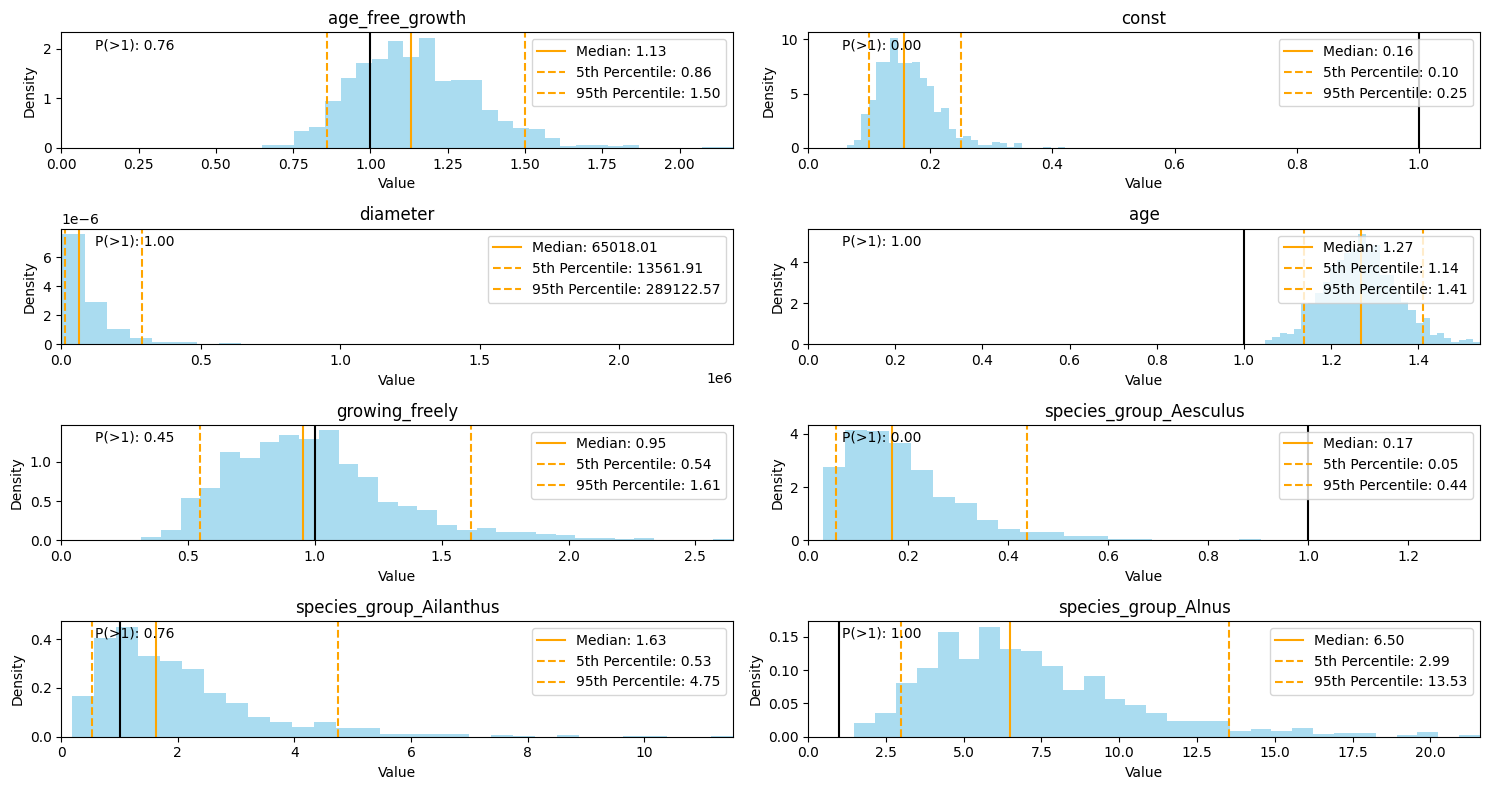

In [24]:
# Calculate statistics for each coefficient
medians = np.median(simulated_betas_odds, axis=0)
lower_quantiles = np.percentile(simulated_betas_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas_odds, 95, axis=0)
prob_positive = np.mean(simulated_betas_odds > 1, axis=0)

# Plot names 
col_names = X_with_intercept.columns

# Plot histograms of each coefficient
coefs_to_plot = 8 # with species dummy variables there are more than 40 coefficients
num_rows = coefs_to_plot // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(coefs_to_plot):
    ax = axs[i]
    ax.hist(simulated_betas_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{ col_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1,abs(simulated_betas_odds[:, i]).max())) 
    
# Hide empty subplot
if simulated_betas.shape[1] % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

#### d) Interpret every coefficient in the model. Pay attention to `statistical significance`, and be clear about what the baseline profile over which the effects are calculated is.

#### Answer: 

The intercept: Our baseline odds. The variance for the intercept is high, so given that all other parameters are set to zero, we can't be sure about the exact odds of a tree being tall or not. However, the entire distribution sits firmly at lower values, and we have an extremely small p. So even if we can't be very precise, we can confidently say that for all parameters being zero a tree has a baseline low chance of being tall. All other parameters multiply our baseline odds.

Age_free_growth: with a p of 0.78, and a 90 percentile of being between 0.86 and 1.47, we aren't getting significant results. We can't really assert if this interaction significantly affects the true probability of a tree being tall.

Diameter: the median for our diameter coefficient is comically huge, suggesting an extremely strong relationship between diameter and tallness. This isn't very surprising, considering that tall trees also tend to have bigger trunks. We can see that there is a vast degree of uncertainty around the median.

Age: Age consistently increases the odds of a tree being classified as tall as it increases, but with this high variance we can't precisely pin down by how much this is the case (as per the 90 percentile, plausibly multiplies the odds of being tall between 1.14 and 1.40 for each 10 years above the average).

Growing_freely: with a p of 0.40, it's likely not to be a strong factor in determining the outcome of a tree.

Species_group: Of the three genuses we see, we can see that some have median values above 1, others below. We have a high degree of uncertainty for each genus, maybe this is because we don't have that many of each individual genus. Each of these coefficients represents how much a tree being of a given species multiplies its odds of being tall *compared to every other genus of tree*. It's not surprising that we have more uncertainty for some species than others (one has p=0.78, the two others p=1.00): some trees grow very tall or very small, making them more predictable; other trees may grow to barely the threshold, making it harder to predict if they will be just below or just above 10 meters. 





In [25]:
# Finally, let's get the AIC of the model just to compare with what we did before. 
# Is the added complexity justified ? 
aic = model.aic
print("AIC:", aic)

AIC: 1467.2251602444594


Considering we have a lower AIC value, the complexity should indeed be justified.

## A final note: 

I suspect you will emerge out of this workshop thinking that odds and odds ratios are, at the very least, `tricky`. I agree with you ! Remember you always have the option of using predicted values for your inference, and calculating Relative Risk and Risk Differences between profiles of interests and reference profiles. We will explore this more in the future workshops. 